In [166]:
import pandas as pd
import re
import json
import seaborn as sns
import numpy as np

In [167]:
jets = pd.read_json("jets.json")
details = pd.read_json("jet_details.json")
cleaned_details = pd.DataFrame()

In [168]:
details.head()

,url,image,Crew,Length,Wingspan,Height,Powerplant,Propellers,Maximum speed,Range,...,izdeliye 30,"Climb to 5,000 ft (1,520 m)",Span wings folded,Wing guns,Forward firing guns,Rear cockpit,Anti-radiation missiles,360° turn,Sustained turn time,Upper Wing chord
0,https://wikipedia.org/wiki/AD_Scout,,1,22 ft 9 in (6.93 m),33 ft 5 in (10.19 m),10 ft 3 in (3.12 m),1 × Gnome Monosoupape 9 Type B-2 9-cylinder ai...,2-bladed fixed-pitch propeller,"84 mph (135 km/h, 73 kn) [4]","210 mi (340 km, 180 nmi)[citation needed]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://wikipedia.org/wiki/ACAZ_C.2,https://www.wikipedia.org/wiki/File:ACAZ_C.2_(...,2,8.25 m (27 ft 1 in),12.5 m (41 ft 0 in),3.4 m (11 ft 2 in),1 × Hispano-Suiza 12Ha V-12 water-cooled pisto...,NaN,"250 km/h (160 mph, 130 kn)",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://wikipedia.org/wiki/Adamoli-Cattani_fig...,https://www.wikipedia.org/wiki/File:Adamoli-Ca...,1,6.10 m (20 ft 0 in),8.60 m (28 ft 3 in),NaN,1 × le Rhône M 9-cyl. air-cooled rotary piston...,NaN,"186 km/h (116 mph, 100 kn)",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://wikipedia.org/wiki/Aerfer_Sagittario_2,https://www.wikipedia.org/wiki/File:Ambrosini_...,1,9.50 m (31 ft 2 in),7.50 m (24 ft 7 in),2.02 m (6 ft 8 in),1 × Rolls-Royce Derwent 9 centrifugal-flow tur...,NaN,"1,006 km/h (625 mph, 543 kn)","765 km (475 mi, 413 nmi)[citation needed]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://wikipedia.org/wiki/AEG_Dr.I,https://www.wikipedia.org/wiki/File:AEG_Dr.I_1...,1,6.1 m (20 ft 0 in),9.4 m (30 ft 10 in),NaN,1 × Mercedes D.IIIa[2] 6-cyl water-cooled in-l...,NaN,"170 km/h (110 mph, 92 kn)",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [169]:
nans = details.isna().sum().sort_values()
nans.head(20)

url                     0
image                   0
Powerplant              5
Crew                   22
Length                 25
Maximum speed          40
Wingspan               73
Wing area             114
Empty weight          131
Height                145
Gross weight          196
Service ceiling       276
Guns                  421
Range                 518
Propellers            673
Rate of climb         698
Time to altitude      737
Wing loading          852
Max takeoff weight    855
Airfoil               956
dtype: int64

In [170]:
cleaned_details["url"] = details["url"]

In [171]:
one_two_matching = re.compile("((Two)|(One)|(\d+))", re.IGNORECASE)
crew_cleaned = details["Crew"].str.extract(one_two_matching)[0]

one_regex = re.compile("(one)", re.IGNORECASE)
two_regex = re.compile("(two)", re.IGNORECASE)
crew_cleaned = crew_cleaned.replace(one_regex, 1)
crew_cleaned = crew_cleaned.replace(two_regex, 2)

crew_cleaned = pd.to_numeric(crew_cleaned)

cleaned_details["Crew"] = crew_cleaned


In [172]:
meter_regex = re.compile("(((\d+)?.?(\d+))(\s*m))", re.IGNORECASE)

def get_meters(data: pd.Series):
    data = data.str.extract(meter_regex)[1]
    unwanted_chars = re.compile("[(),]")
    data = data.str.replace(unwanted_chars, "")
    data = pd.to_numeric(data)
    return data


In [173]:
meter_columns = details[["Wing area",
                         "Service ceiling",
                         "Rate of climb",
                         "Wingspan",
                         "Height",
                         "Length"]].apply(get_meters)

In [174]:
cleaned_details = pd.concat([cleaned_details, meter_columns], axis=1)

In [175]:
raw_speed = details["Maximum speed"]
speed_extract = re.compile("(((\d+)(.\d+)?)(\s*km/h))", re.IGNORECASE)
mach_extract = re.compile("(mach\s*)((\d+)(\.\d+)?)", re.IGNORECASE)
speed_kmh = raw_speed.str.extract(speed_extract)[1]
speed_kmh = speed_kmh.str.replace(",", "")
highest_speed_extract = re.compile("(\d+)–")
speed_kmh = speed_kmh.str.replace(highest_speed_extract, "")
speed_kmh = pd.to_numeric(speed_kmh)

machs = pd.to_numeric(raw_speed.str.extract(mach_extract)[1])

speed_kmh = speed_kmh.fillna(machs * 1234.8)

cleaned_details["Maximum speed"] = speed_kmh

In [176]:
raw_weight = details[["Empty weight", "Gross weight"]]

weight_regex = re.compile("(((\d+)(.\d+)?)(\s*kg))", re.IGNORECASE)

def get_weight(data: pd.Series):
    data = data.str.extract(weight_regex)[1]
    data = data.str.replace(",", "")
    data = pd.to_numeric(data)
    return data

weight = raw_weight.apply(get_weight)
cleaned_details = pd.concat([cleaned_details, weight], axis=1)

In [177]:
cleaned_details.head()

,url,Crew,Wing area,Service ceiling,Rate of climb,Wingspan,Height,Length,Maximum speed,Empty weight,Gross weight
0,https://wikipedia.org/wiki/AD_Scout,1.0,NaN,NaN,NaN,10.19,3.12,6.93,135.0,NaN,NaN
1,https://wikipedia.org/wiki/ACAZ_C.2,2.0,40.56,NaN,NaN,12.50,3.40,8.25,250.0,1260.0,2070.0
2,https://wikipedia.org/wiki/Adamoli-Cattani_fig...,1.0,NaN,NaN,NaN,8.60,NaN,6.10,186.0,470.0,675.0
3,https://wikipedia.org/wiki/Aerfer_Sagittario_2,1.0,14.73,14000.0,42.0,7.50,2.02,9.50,1006.0,2300.0,3293.0
4,https://wikipedia.org/wiki/AEG_Dr.I,1.0,NaN,NaN,NaN,9.40,NaN,6.10,170.0,710.0,970.0


In [178]:
cleaned_jets = pd.DataFrame()


In [179]:
raw_number_created = jets["number created"]
number_extract = re.compile("((\d+)(.\d+)?)")
number_created = raw_number_created.str.extract(number_extract)[0]
number_created = number_created.str.replace(",", "")
number_created = pd.to_numeric(number_created)

cleaned_jets["number created"] = number_created

In [180]:
raw_year = jets["year"]
year_regex = re.compile("(\d+)")
year = raw_year.str.extract(year_regex)[0]
year = pd.to_numeric(year)

cleaned_jets["year"] = year


In [181]:
cleaned_jets.head()

,number created,year
0,1.0,1926.0
1,1.0,1918.0
2,4.0,1915.0
3,0.0,NaN
4,3.0,1917.0


In [182]:
cleaned_jets = pd.concat([cleaned_jets, jets.drop(["year", "number created"], axis=1)], axis=1)
clean = cleaned_details.merge(cleaned_jets, on="url")

In [183]:
clean = clean.replace("", np.NaN)

In [184]:
clean.head()

,url,Crew,Wing area,Service ceiling,Rate of climb,Wingspan,Height,Length,Maximum speed,Empty weight,Gross weight,number created,year,name,country,class,status,notes
0,https://wikipedia.org/wiki/AD_Scout,1.0,NaN,NaN,NaN,10.19,3.12,6.93,135.0,NaN,NaN,4.0,1915.0,AD Scout,UK,NaN,Prototype,NaN
1,https://wikipedia.org/wiki/ACAZ_C.2,2.0,40.56,NaN,NaN,12.50,3.40,8.25,250.0,1260.0,2070.0,1.0,1926.0,ACAZ C.2,Belgium,NaN,Prototype,Two-seat fighter
2,https://wikipedia.org/wiki/Adamoli-Cattani_fig...,1.0,NaN,NaN,NaN,8.60,NaN,6.10,186.0,470.0,675.0,1.0,1918.0,Adamoli-Cattani fighter,Italy,NaN,Prototype,NaN
3,https://wikipedia.org/wiki/Aerfer_Sagittario_2,1.0,14.73,14000.0,42.0,7.50,2.02,9.50,1006.0,2300.0,3293.0,2.0,1956.0,Aerfer Sagittario 2,Italy,NaN,Prototype,Lightweight fighter
4,https://wikipedia.org/wiki/AEG_Dr.I,1.0,NaN,NaN,NaN,9.40,NaN,6.10,170.0,710.0,970.0,1.0,1917.0,AEG Dr.I,Germany,NaN,Prototype,Triplane


In [185]:
clean.describe()

,Crew,Wing area,Service ceiling,Rate of climb,Wingspan,Height,Length,Maximum speed,Empty weight,Gross weight,number created,year
count,1116.000000,1041.000000,896.000000,501.000000,1074.000000,1012.000000,1118.000000,1095.000000,1024.000000,954.000000,1140.000000,1137.000000
mean,1.267921,27.660971,9922.875112,47.227257,10.993944,3.440983,9.590281,596.322583,3032.791016,4235.236897,549.770175,1935.520668
std,0.761690,13.759464,4175.640139,85.556278,2.733746,1.040041,3.827415,608.472460,3770.210939,5743.324325,2230.025652,18.703670
min,1.000000,4.700000,997.400000,0.110000,4.000000,1.100000,4.260000,106.000000,129.000000,223.000000,0.000000,1913.000000
25%,1.000000,19.000000,7000.000000,8.000000,9.177500,2.760000,7.100000,223.000000,849.250000,1176.000000,1.000000,1920.000000
50%,1.000000,23.900000,9300.000000,14.000000,10.560000,3.175000,8.250000,352.000000,1405.000000,1886.500000,4.000000,1933.000000
75%,1.000000,32.000000,12000.000000,34.300000,12.000000,3.880000,10.970000,660.000000,3769.000000,5000.000000,141.000000,1943.000000
max,18.000000,167.000000,27400.000000,1005.000000,25.000000,16.080000,30.970000,3661.000000,27604.000000,56200.000000,33984.000000,2016.000000


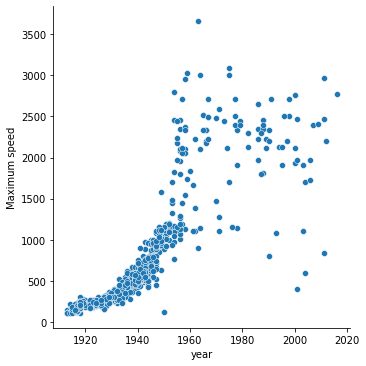

In [186]:
sns.relplot(x="year", y="Maximum speed", data=clean)

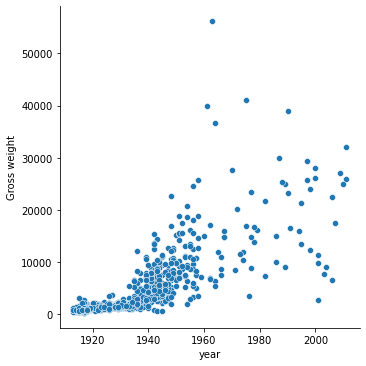

In [187]:
sns.relplot(x="year", y="Gross weight", data=clean)

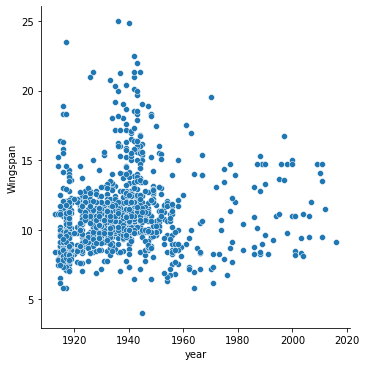

In [188]:
sns.relplot(x="year", y="Wingspan", data=clean)

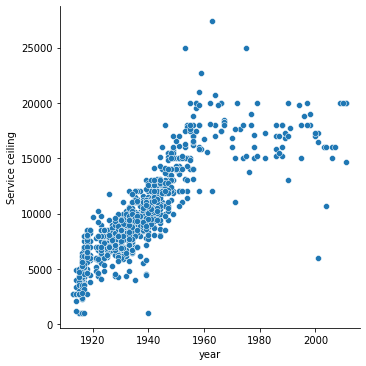

In [189]:
sns.relplot(x="year", y="Service ceiling", data=clean)

In [190]:
stuff = clean[clean["year"] < 1940]
thing = stuff[stuff["Maximum speed"] > 2000].head(5)

In [191]:
with open("jet_details.json") as f:
    og_detail_data = json.load(f)


In [192]:
all_data = []
for item in og_detail_data:
    data_to_add = clean[clean["url"] == item["url"]].dropna(axis=1).to_dict("records")
    if len(data_to_add) > 0:
        item.update(data_to_add[0])
        all_data.append(item)

In [193]:
with open('final_jet_data.json', 'w', encoding='utf-8') as f:
    json.dump(all_data, f, indent=4)